In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
import torch.nn.functional as F
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
nltk.download('wordnet', quiet=True)

True

In [33]:
# Check CUDA availability for GPU acceleration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [34]:
# Model hyperparameters
# --- Word Level ---
WORD_EMBEDDING_DIM = 300   # Dimension of word embeddings
HIDDEN_DIM = 256           # Hidden dimension for LSTM
NUM_LAYERS = 2             # Number of LSTM layers
DROPOUT = 0.5              # Dropout rate for regularization
MIN_WORD_FREQ = 3          # Minimum word frequency to include in vocabulary
MAX_SEQ_LENGTH = 40        # Maximum number of words in a sequence

# --- Character Level ---
CHAR_EMBED_DIM = 50        # Dimension of character embeddings
CHAR_CNN_OUT_CHANNELS = 100  # Output channels from Character CNN
MAX_WORD_LENGTH = 15       # Maximum characters per word

# --- Training ---
LEARNING_RATE = 3e-4       # Initial learning rate
BATCH_SIZE = 32            # Batch size for training
NUM_EPOCHS = 50            # Maximum number of training epochs
WEIGHT_DECAY = 1e-5        # Weight decay for regularization

In [35]:
# Text preprocessing function
def clean_text(text):
    """
    Preprocesses text by converting to lowercase, removing special characters,
    and applying lemmatization.

    Args:
        text (str): Input text string

    Returns:
        str: Cleaned and preprocessed text
    """
    if not isinstance(text, str):
        return ""

    lemmatizer = WordNetLemmatizer()

    # Keep letters, numbers, whitespace, plus signs, and hash symbols
    # (important for programming-related text)
    text = re.sub(r"[^a-zA-Z0-9\s+#]", "", text.lower())

    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words]

    return " ".join(words)

In [36]:
# --- BigQuery setup ---
from google.colab import drive
from google.cloud import bigquery
from google.colab import auth

auth.authenticate_user()
print('Authenticated')

Authenticated


In [37]:
project_id = "" # Replace with your project ID

In [38]:
%%bigquery df --project $project_id
SELECT title, tags
FROM `bigquery-public-data.stackoverflow.posts_questions` as Posts
WHERE ARRAY_LENGTH(SPLIT(Posts.tags, '|')) = 1 AND tags in (
  SELECT tags
  FROM `bigquery-public-data.stackoverflow.posts_questions` as Posts
  WHERE ARRAY_LENGTH(SPLIT(Posts.tags, '|')) = 1
  GROUP BY tags
  ORDER BY COUNT(*) DESC
  LIMIT 10
)
ORDER BY RAND()
LIMIT 120000

Query is running:   0%|          |

Downloading:   0%|          |

In [39]:
# Clean and preprocess the text data
print("Cleaning text data...")
df['clean_title'] = df['title'].apply(clean_text)
df = df.dropna(subset=['clean_title'])
df = df[df['clean_title'].str.strip() != ""]  # Remove empty titles
df = df.drop_duplicates(subset='clean_title')
print(f"Dataset size after cleaning and deduplication: {len(df)}")

Cleaning text data...
Dataset size after cleaning and deduplication: 119929


## Data exploration

In [40]:
# Data exploration: Examine the dataset
print("Dataset Overview:")
print(f"Total samples: {len(df)}")
print(f"Number of unique tags: {df['tags'].nunique()}")

# Display sample titles and tags
print("\nSample titles and tags:")
sample_df = df.sample(5)
for idx, row in sample_df.iterrows():
    print(f"Title: {row['title']}")
    print(f"Tag: {row['tags']}")
    print(f"Clean Title: {row['clean_title']}")
    print("-" * 50)

Dataset Overview:
Total samples: 119929
Number of unique tags: 10

Sample titles and tags:
Title: Setting properties from CSV file using eval (Python)
Tag: python
Clean Title: setting property from csv file using eval python
--------------------------------------------------
Title: How to send an Email automatically using Android Studio
Tag: android
Clean Title: how to send an email automatically using android studio
--------------------------------------------------
Title: Android detect date change event
Tag: android
Clean Title: android detect date change event
--------------------------------------------------
Title: calling a http get request in java
Tag: java
Clean Title: calling a http get request in java
--------------------------------------------------
Title: jQuery on() method is firing more than one time
Tag: jquery
Clean Title: jquery on method is firing more than one time
--------------------------------------------------


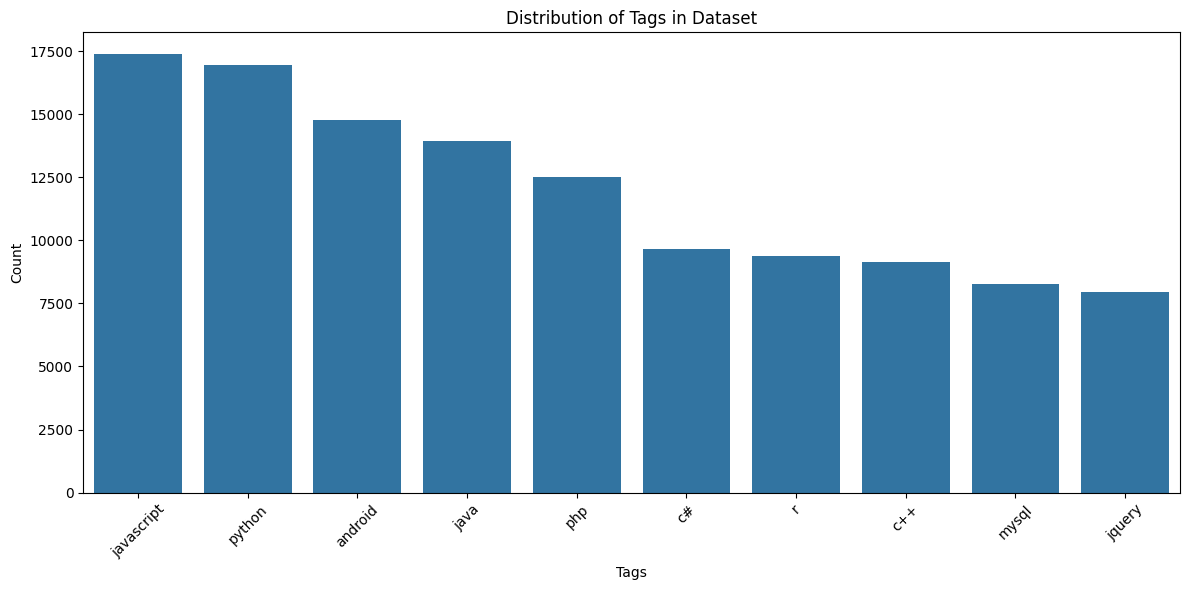

Top 10 tags by frequency:
javascript: 17380 (14.49%)
python: 16937 (14.12%)
android: 14755 (12.30%)
java: 13931 (11.62%)
php: 12522 (10.44%)
c#: 9671 (8.06%)
r: 9397 (7.84%)
c++: 9135 (7.62%)
mysql: 8261 (6.89%)
jquery: 7940 (6.62%)


In [41]:
# Visualize tag distribution
plt.figure(figsize=(12, 6))
tag_counts = df['tags'].value_counts()
sns.barplot(x=tag_counts.index, y=tag_counts.values)
plt.title('Distribution of Tags in Dataset')
plt.xlabel('Tags')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Top 10 tags by frequency:")
for tag, count in tag_counts.items():
    print(f"{tag}: {count} ({count / len(df) * 100:.2f}%)")

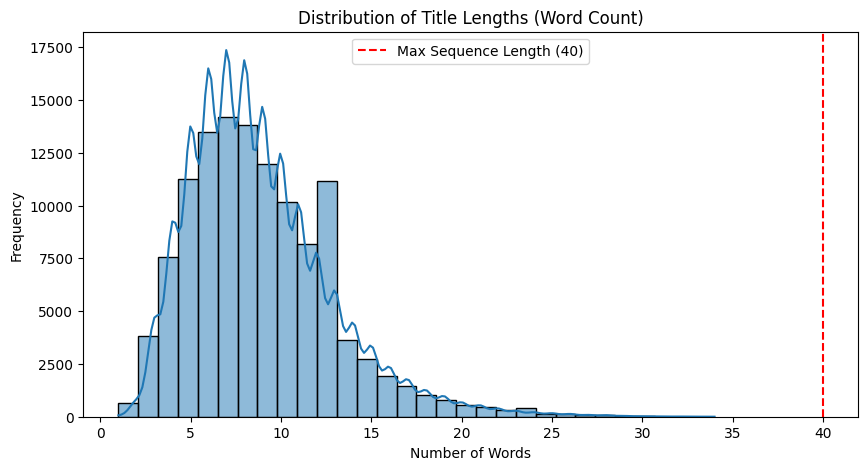

Title length statistics:
Mean: 8.82 words
Median: 8.0 words
Max: 34 words
Min: 1 words
Percentage of titles with <= 40 words: 100.00%


In [42]:
# Analyze title length distribution
title_lengths = df['clean_title'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 5))
sns.histplot(title_lengths, bins=30, kde=True)
plt.title('Distribution of Title Lengths (Word Count)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.axvline(x=MAX_SEQ_LENGTH, color='r', linestyle='--', label=f'Max Sequence Length ({MAX_SEQ_LENGTH})')
plt.legend()
plt.show()

print(f"Title length statistics:")
print(f"Mean: {title_lengths.mean():.2f} words")
print(f"Median: {title_lengths.median()} words")
print(f"Max: {title_lengths.max()} words")
print(f"Min: {title_lengths.min()} words")
print(f"Percentage of titles with <= {MAX_SEQ_LENGTH} words: {(title_lengths <= MAX_SEQ_LENGTH).mean() * 100:.2f}%")

In [43]:
# Split data into train, validation, and test sets (70% / 15% / 15%)
if len(df) < 100:
    print("Insufficient data after cleaning. Exiting.")
    exit()

tv_thresh = int(0.7 * len(df))
vt_thresh = int(0.85 * len(df))

train_df = df[:tv_thresh]
val_df = df[tv_thresh:vt_thresh]
test_df = df[vt_thresh:]

train_X = train_df['clean_title'].values
val_X = val_df['clean_title'].values
test_X = test_df['clean_title'].values

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 83950
Validation set size: 17989
Test set size: 17990


## Label Encoding and Class Weights

In [44]:
label_encoder = LabelEncoder()

df['encoded_tags'] = label_encoder.fit_transform(df['tags'])
num_classes = len(label_encoder.classes_)

# Apply encoding to splits
train_y = label_encoder.transform(train_df['tags'])
val_y = label_encoder.transform(val_df['tags'])
test_y = label_encoder.transform(test_df['tags'])

print(f"Number of classes: {num_classes}")
print("Class distribution (overall):")
counts = df['tags'].value_counts()
for tag, count in counts.items():
    print(f"{tag}: {count} ({count / len(df) * 100:.2f}%)")

Number of classes: 10
Class distribution (overall):
javascript: 17380 (14.49%)
python: 16937 (14.12%)
android: 14755 (12.30%)
java: 13931 (11.62%)
php: 12522 (10.44%)
c#: 9671 (8.06%)
r: 9397 (7.84%)
c++: 9135 (7.62%)
mysql: 8261 (6.89%)
jquery: 7940 (6.62%)


In [45]:
train_labels_for_weights = label_encoder.transform(train_df['tags'])
class_weights_np = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_labels_for_weights),
    y=train_labels_for_weights
)
class_weights = torch.tensor(class_weights_np, dtype=torch.float).to(device)
print("Class weights calculated to balance training:")
for i, weight in enumerate(class_weights_np):
    print(f"{label_encoder.classes_[i]}: {weight:.4f}")

Class weights calculated to balance training:
android: 0.8117
c#: 1.2364
c++: 1.3216
java: 0.8663
javascript: 0.6896
jquery: 1.5275
mysql: 1.4549
php: 0.9594
python: 0.7027
r: 1.2643


## Vocabulary Building

In [46]:
print("Building vocabularies...")
word_freq = {}
char_set = set()
for text in train_X:
    for word in text.split():
        word_freq[word] = word_freq.get(word, 0) + 1
        for char in word:
            char_set.add(char)

word_vocab = {'<pad>': 0, '<unk>': 1}
for word, freq in word_freq.items():
    if freq >= MIN_WORD_FREQ:
        word_vocab[word] = len(word_vocab)

char_vocab = {'<pad>': 0, '<unk>': 1}
for char in sorted(list(char_set)):
    char_vocab[char] = len(char_vocab)

word_vocab_size = len(word_vocab)
char_vocab_size = len(char_vocab)
print(f"Word Vocabulary size: {word_vocab_size}")
print(f"Character Vocabulary size: {char_vocab_size}")

Building vocabularies...
Word Vocabulary size: 6877
Character Vocabulary size: 40


In [47]:
class TextDataset(Dataset):
    """
    Dataset class for text classification that processes both word-level
    and character-level features.

    Args:
        texts (list): List of text samples
        labels (list): List of corresponding labels
        word_vocab (dict): Word-to-index vocabulary mapping
        char_vocab (dict): Character-to-index vocabulary mapping
        max_seq_len (int): Maximum sequence length for padding/truncating
        max_word_len (int): Maximum word length for padding/truncating characters
    """
    def __init__(self, texts, labels, word_vocab, char_vocab, max_seq_len, max_word_len):
        self.texts = texts
        self.labels = labels
        self.word_vocab = word_vocab
        self.char_vocab = char_vocab
        self.max_seq_len = max_seq_len
        self.max_word_len = max_word_len
        self.word_pad_idx = word_vocab['<pad>']
        self.word_unk_idx = word_vocab['<unk>']
        self.char_pad_idx = char_vocab['<pad>']
        self.char_unk_idx = char_vocab['<unk>']

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        words = text.split()

        word_indices = [self.word_vocab.get(word, self.word_unk_idx) for word in words]

        char_indices_word_list = []
        for word in words:
            chars = [self.char_vocab.get(char, self.char_unk_idx) for char in word]
            # Pad/truncate characters within a word
            if len(chars) > self.max_word_len:
                chars = chars[:self.max_word_len]
            else:
                chars += [self.char_pad_idx] * (self.max_word_len - len(chars))
            char_indices_word_list.append(chars)

        seq_len = len(word_indices)
        if seq_len > self.max_seq_len:
            word_indices = word_indices[:self.max_seq_len]
            char_indices_word_list = char_indices_word_list[:self.max_seq_len]
        else:
            word_indices += [self.word_pad_idx] * (self.max_seq_len - seq_len)
            # Pad character list with sequences of char_pad_idx
            pad_chars = [self.char_pad_idx] * self.max_word_len
            char_indices_word_list += [pad_chars] * (self.max_seq_len - seq_len)

        return (torch.tensor(word_indices, dtype=torch.long),
                torch.tensor(char_indices_word_list, dtype=torch.long)), \
            torch.tensor(label, dtype=torch.long)

## Data Preparation

In [48]:
# Create datasets for training, validation, and testing
train_dataset = TextDataset(train_X, train_y, word_vocab, char_vocab, MAX_SEQ_LENGTH, MAX_WORD_LENGTH)
val_dataset = TextDataset(val_X, val_y, word_vocab, char_vocab, MAX_SEQ_LENGTH, MAX_WORD_LENGTH)
test_dataset = TextDataset(test_X, test_y, word_vocab, char_vocab, MAX_SEQ_LENGTH, MAX_WORD_LENGTH)

# Create dataloaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Testing samples: {len(test_dataset)}")
if len(train_dataset) == 0 or len(val_dataset) == 0 or len(test_dataset) == 0:
    print("Error: One or more datasets are empty. Check data splitting and cleaning.")
    exit()

Training samples: 83950
Validation samples: 17989
Testing samples: 17990


## Model Definition

In [49]:
# Attention mechanism for the model
class AttentionLayer(nn.Module):
    """
    Attention mechanism that computes a weighted sum of LSTM outputs.

    Args:
        hidden_dim (int): Dimension of the hidden state
    """
    def __init__(self, hidden_dim):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Linear(hidden_dim * 2, 1, bias=False)

    def forward(self, lstm_output):
        energy = torch.tanh(self.attention(lstm_output))
        attention_weights = F.softmax(energy, dim=1)

        context_vector = torch.sum(attention_weights * lstm_output, dim=1)
        return context_vector, attention_weights.squeeze(2)

In [50]:
# Enhanced model architecture combining character CNN and word-level BiLSTM with attention
class EnhancedTextModel(nn.Module):
    """
    Neural network model for text classification that combines:
    1. Word embeddings
    2. Character-level CNN
    3. Bidirectional LSTM
    4. Attention mechanism

    Args:
        word_vocab_size (int): Size of the word vocabulary
        char_vocab_size (int): Size of the character vocabulary
        word_embed_dim (int): Dimension of word embeddings
        char_embed_dim (int): Dimension of character embeddings
        char_cnn_out_channels (int): Output channels from character CNN
        hidden_dim (int): Hidden dimension for LSTM
        num_layers (int): Number of LSTM layers
        num_classes (int): Number of output classes
        dropout (float): Dropout rate for regularization
        word_pad_idx (int): Padding index for words
        char_pad_idx (int): Padding index for characters
    """
    def __init__(self, word_vocab_size, char_vocab_size, word_embed_dim, char_embed_dim,
                 char_cnn_out_channels, hidden_dim, num_layers, num_classes,
                 dropout=0.5, word_pad_idx=0, char_pad_idx=0):
        super(EnhancedTextModel, self).__init__()

        self.word_pad_idx = word_pad_idx
        self.char_pad_idx = char_pad_idx

        # Word Embedding Layer
        self.word_embedding = nn.Embedding(word_vocab_size, word_embed_dim, padding_idx=word_pad_idx)

        # Character Embedding Layer
        self.char_embedding = nn.Embedding(char_vocab_size, char_embed_dim, padding_idx=char_pad_idx)

        # Character CNN Layer
        self.char_cnn = nn.Conv1d(in_channels=char_embed_dim,
                                  out_channels=char_cnn_out_channels,
                                  kernel_size=3,
                                  padding=1)

        # Combined input dimension for LSTM
        lstm_input_dim = word_embed_dim + char_cnn_out_channels

        # BiLSTM Layer
        self.lstm = nn.LSTM(
            lstm_input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Attention Layer
        self.attention = AttentionLayer(hidden_dim)

        # Fully Connected Layers for classification
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.dropout_layer = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, inputs):
        word_inputs, char_inputs = inputs

        batch_size, seq_len = word_inputs.shape
        word_len = char_inputs.shape[2]

        word_embedded = self.word_embedding(word_inputs)  # [batch_size, seq_len, word_embed_dim]

        char_embedded = self.char_embedding(char_inputs)  # [batch_size, seq_len, word_len, char_embed_dim]
        char_embedded_reshaped = char_embedded.view(batch_size * seq_len, word_len, -1)
        char_embedded_permuted = char_embedded_reshaped.permute(0, 2, 1)  # For Conv1d [B*S, C, L]

        # Apply CNN and max pooling
        char_cnn_out = F.relu(self.char_cnn(char_embedded_permuted))
        char_features = F.max_pool1d(char_cnn_out, char_cnn_out.shape[2]).squeeze(2)
        char_features_reshaped = char_features.view(batch_size, seq_len, -1)

        combined_embedded = torch.cat((word_embedded, char_features_reshaped), dim=2)
        combined_embedded = self.dropout_layer(combined_embedded)

        lstm_output, _ = self.lstm(combined_embedded)

        context_vector, _ = self.attention(lstm_output)

        x = self.fc1(context_vector)
        x = F.relu(x)
        x = self.dropout_layer(x)
        x = self.layer_norm(x)
        x = self.fc2(x)

        return x

## Training and Evaluation

In [51]:
# Initialize and print model architecture
model = EnhancedTextModel(
    word_vocab_size=word_vocab_size,
    char_vocab_size=char_vocab_size,
    word_embed_dim=WORD_EMBEDDING_DIM,
    char_embed_dim=CHAR_EMBED_DIM,
    char_cnn_out_channels=CHAR_CNN_OUT_CHANNELS,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    num_classes=num_classes,
    dropout=DROPOUT,
    word_pad_idx=word_vocab['<pad>'],
    char_pad_idx=char_vocab['<pad>']
).to(device)

print(model)
print(f"Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

EnhancedTextModel(
  (word_embedding): Embedding(6877, 300, padding_idx=0)
  (char_embedding): Embedding(40, 50, padding_idx=0)
  (char_cnn): Conv1d(50, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (attention): AttentionLayer(
    (attention): Linear(in_features=512, out_features=1, bias=False)
  )
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)
Total trainable parameters: 5,139,666


In [52]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
total_steps = len(train_loader) * NUM_EPOCHS
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=1e-6)

In [53]:
# Early stopping to prevent overfitting
class EarlyStopping:
    """
    Early stopping implementation to halt training when validation loss stops improving.

    Args:
        patience (int): How many epochs to wait after last improvement
        min_delta (float): Minimum change to qualify as an improvement
        verbose (bool): Whether to print progress messages
    """
    def __init__(self, patience=5, min_delta=0.001, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.verbose = verbose

    def __call__(self, val_loss):
        # If validation loss improved by at least min_delta
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True


early_stopping = EarlyStopping(patience=5, verbose=True)

In [54]:
# Training loop
best_val_acc = 0
best_model_path = 'stackoverflow_classifier.pt'

# For plotting training history
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'lr': []
}

print("Starting training...")
for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} [Train]")
    for batch_idx, (inputs, labels) in enumerate(train_pbar):
        word_inputs, char_inputs = inputs
        word_inputs, char_inputs = word_inputs.to(device), char_inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model((word_inputs, char_inputs))
        loss = criterion(outputs, labels)

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        scheduler.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        train_acc = 100 * correct_train / total_train
        lr = optimizer.param_groups[0]['lr']
        train_pbar.set_postfix({
            'loss': total_train_loss / (batch_idx + 1),
            'acc': f"{train_acc:.2f}%",
            'lr': f"{lr:.1e}"
        })

    # Validation phase
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} [Val]")
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(val_pbar):
            word_inputs, char_inputs = inputs
            word_inputs, char_inputs = word_inputs.to(device), char_inputs.to(device)
            labels = labels.to(device)

            outputs = model((word_inputs, char_inputs))
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            val_acc = 100 * correct_val / total_val
            val_pbar.set_postfix({
                'loss': total_val_loss / (batch_idx + 1),
                'acc': f"{val_acc:.2f}%"
            })

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_accuracy = 100 * correct_train / total_train
    val_accuracy = 100 * correct_val / total_val

    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['train_acc'].append(train_accuracy)
    history['val_acc'].append(val_accuracy)
    history['lr'].append(optimizer.param_groups[0]['lr'])

    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS} Summary:")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%")
    print(f"  Val Loss:   {avg_val_loss:.4f}, Val Acc:   {val_accuracy:.2f}%")

    # Save the best model based on validation accuracy
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"  Best model saved with validation accuracy: {best_val_acc:.2f}%")
        early_stopping.counter = 0

    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

    gc.collect()
    if device == 'cuda':
        torch.cuda.empty_cache()

Starting training...


Epoch 1/50 [Val]: 100%|██████████| 563/563 [00:05<00:00, 106.52it/s, loss=0.93, acc=68.31%]



Epoch 1/50 Summary:
  Train Loss: 1.1532, Train Acc: 59.06%
  Val Loss:   0.9296, Val Acc:   68.31%
  Best model saved with validation accuracy: 68.31%


Epoch 2/50 [Val]: 100%|██████████| 563/563 [00:05<00:00, 97.05it/s, loss=0.876, acc=71.16%] 



Epoch 2/50 Summary:
  Train Loss: 0.9098, Train Acc: 67.60%
  Val Loss:   0.8761, Val Acc:   71.16%
  Best model saved with validation accuracy: 71.16%


Epoch 3/50 [Val]: 100%|██████████| 563/563 [00:06<00:00, 93.10it/s, loss=0.85, acc=72.66%]



Epoch 3/50 Summary:
  Train Loss: 0.8337, Train Acc: 70.08%
  Val Loss:   0.8500, Val Acc:   72.66%
  Best model saved with validation accuracy: 72.66%


Epoch 4/50 [Val]: 100%|██████████| 563/563 [00:05<00:00, 105.29it/s, loss=0.808, acc=73.70%]



Epoch 4/50 Summary:
  Train Loss: 0.7913, Train Acc: 71.58%
  Val Loss:   0.8078, Val Acc:   73.70%
  Best model saved with validation accuracy: 73.70%


Epoch 5/50 [Val]: 100%|██████████| 563/563 [00:05<00:00, 104.55it/s, loss=0.84, acc=74.13%]



Epoch 5/50 Summary:
  Train Loss: 0.7559, Train Acc: 72.81%
  Val Loss:   0.8400, Val Acc:   74.13%
  Best model saved with validation accuracy: 74.13%
EarlyStopping counter: 1 out of 5


Epoch 6/50 [Val]: 100%|██████████| 563/563 [00:06<00:00, 92.36it/s, loss=0.813, acc=73.97%] 



Epoch 6/50 Summary:
  Train Loss: 0.7286, Train Acc: 73.81%
  Val Loss:   0.8128, Val Acc:   73.97%
EarlyStopping counter: 2 out of 5


Epoch 7/50 [Val]: 100%|██████████| 563/563 [00:05<00:00, 101.41it/s, loss=0.805, acc=74.56%]



Epoch 7/50 Summary:
  Train Loss: 0.7043, Train Acc: 74.71%
  Val Loss:   0.8054, Val Acc:   74.56%
  Best model saved with validation accuracy: 74.56%


Epoch 8/50 [Val]: 100%|██████████| 563/563 [00:05<00:00, 106.50it/s, loss=0.816, acc=75.02%]



Epoch 8/50 Summary:
  Train Loss: 0.6797, Train Acc: 75.40%
  Val Loss:   0.8164, Val Acc:   75.02%
  Best model saved with validation accuracy: 75.02%
EarlyStopping counter: 1 out of 5


Epoch 9/50 [Val]: 100%|██████████| 563/563 [00:06<00:00, 92.30it/s, loss=0.824, acc=75.17%] 



Epoch 9/50 Summary:
  Train Loss: 0.6660, Train Acc: 75.86%
  Val Loss:   0.8237, Val Acc:   75.17%
  Best model saved with validation accuracy: 75.17%
EarlyStopping counter: 1 out of 5


Epoch 10/50 [Val]: 100%|██████████| 563/563 [00:06<00:00, 93.41it/s, loss=0.795, acc=75.27%]



Epoch 10/50 Summary:
  Train Loss: 0.6490, Train Acc: 76.63%
  Val Loss:   0.7952, Val Acc:   75.27%
  Best model saved with validation accuracy: 75.27%


Epoch 11/50 [Val]: 100%|██████████| 563/563 [00:05<00:00, 104.50it/s, loss=0.826, acc=75.56%]



Epoch 11/50 Summary:
  Train Loss: 0.6303, Train Acc: 77.20%
  Val Loss:   0.8261, Val Acc:   75.56%
  Best model saved with validation accuracy: 75.56%
EarlyStopping counter: 1 out of 5


Epoch 12/50 [Val]: 100%|██████████| 563/563 [00:05<00:00, 105.66it/s, loss=0.859, acc=75.25%]



Epoch 12/50 Summary:
  Train Loss: 0.6168, Train Acc: 77.59%
  Val Loss:   0.8589, Val Acc:   75.25%
EarlyStopping counter: 2 out of 5


Epoch 13/50 [Val]: 100%|██████████| 563/563 [00:06<00:00, 93.11it/s, loss=0.873, acc=75.37%]



Epoch 13/50 Summary:
  Train Loss: 0.5981, Train Acc: 78.25%
  Val Loss:   0.8728, Val Acc:   75.37%
EarlyStopping counter: 3 out of 5


Epoch 14/50 [Val]: 100%|██████████| 563/563 [00:05<00:00, 101.94it/s, loss=0.85, acc=75.77%]



Epoch 14/50 Summary:
  Train Loss: 0.5893, Train Acc: 78.55%
  Val Loss:   0.8502, Val Acc:   75.77%
  Best model saved with validation accuracy: 75.77%
EarlyStopping counter: 1 out of 5


Epoch 15/50 [Val]: 100%|██████████| 563/563 [00:05<00:00, 101.04it/s, loss=0.881, acc=75.64%]



Epoch 15/50 Summary:
  Train Loss: 0.5731, Train Acc: 79.03%
  Val Loss:   0.8805, Val Acc:   75.64%
EarlyStopping counter: 2 out of 5


Epoch 16/50 [Val]: 100%|██████████| 563/563 [00:05<00:00, 96.94it/s, loss=0.913, acc=75.94%]



Epoch 16/50 Summary:
  Train Loss: 0.5615, Train Acc: 79.44%
  Val Loss:   0.9131, Val Acc:   75.94%
  Best model saved with validation accuracy: 75.94%
EarlyStopping counter: 1 out of 5


Epoch 17/50 [Val]: 100%|██████████| 563/563 [00:05<00:00, 94.74it/s, loss=0.905, acc=75.55%]



Epoch 17/50 Summary:
  Train Loss: 0.5498, Train Acc: 80.00%
  Val Loss:   0.9049, Val Acc:   75.55%
EarlyStopping counter: 2 out of 5


Epoch 18/50 [Val]: 100%|██████████| 563/563 [00:05<00:00, 104.72it/s, loss=0.878, acc=75.87%]



Epoch 18/50 Summary:
  Train Loss: 0.5388, Train Acc: 80.09%
  Val Loss:   0.8784, Val Acc:   75.87%
EarlyStopping counter: 3 out of 5


Epoch 19/50 [Val]: 100%|██████████| 563/563 [00:05<00:00, 104.09it/s, loss=0.916, acc=75.91%]



Epoch 19/50 Summary:
  Train Loss: 0.5252, Train Acc: 80.62%
  Val Loss:   0.9162, Val Acc:   75.91%
EarlyStopping counter: 4 out of 5


Epoch 20/50 [Val]: 100%|██████████| 563/563 [00:06<00:00, 92.73it/s, loss=0.947, acc=75.87%]


Epoch 20/50 Summary:
  Train Loss: 0.5169, Train Acc: 81.07%
  Val Loss:   0.9474, Val Acc:   75.87%
EarlyStopping counter: 5 out of 5
Early stopping triggered.


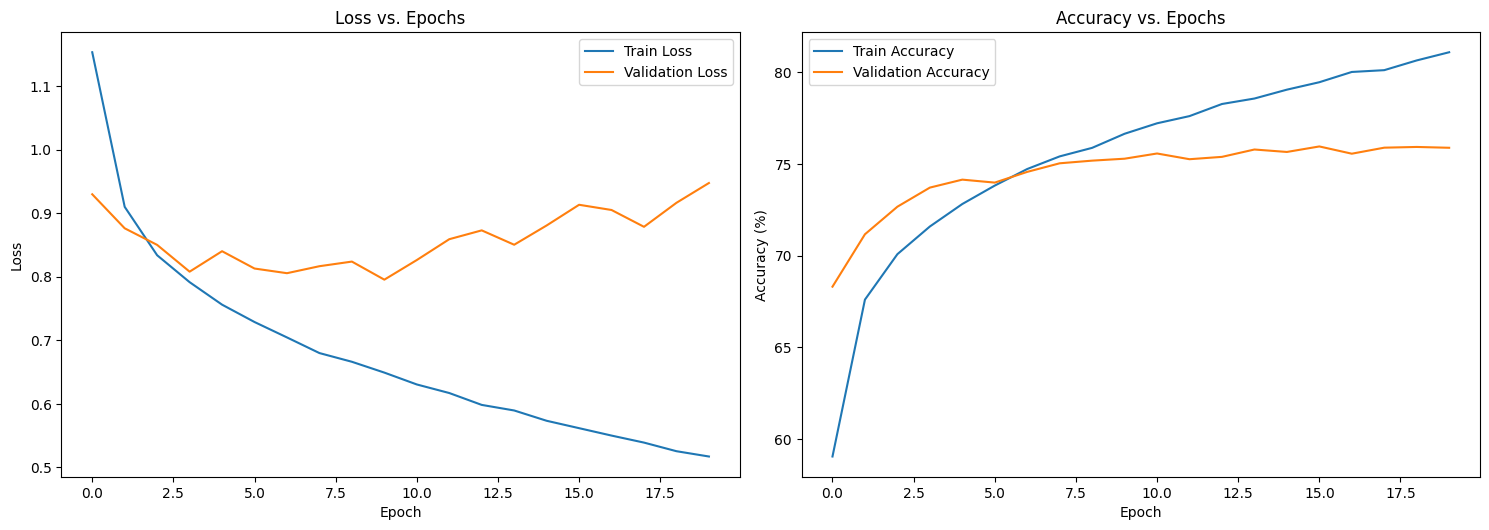

In [55]:
# Plot training history
plt.figure(figsize=(15, 10))

# Plot loss
plt.subplot(2, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(2, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [56]:
# Load the best model for evaluation
print(f"Loading best model from {best_model_path} with Val Acc: {best_val_acc:.2f}%")
model.load_state_dict(torch.load(best_model_path))

model.eval()
correct_test = 0
total_test = 0
class_correct = [0] * num_classes
class_total = [0] * num_classes
all_predictions = []
all_true_labels = []
total_test_loss = 0

print("Evaluating on Test Set...")
test_pbar = tqdm(test_loader, desc="Testing")
with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(test_pbar):
        word_inputs, char_inputs = inputs
        word_inputs, char_inputs = word_inputs.to(device), char_inputs.to(device)
        labels = labels.to(device)

        outputs = model((word_inputs, char_inputs))
        loss = criterion(outputs, labels)
        total_test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)

        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        for i in range(labels.size(0)):
            label = labels[i].item()
            class_total[label] += 1
            if predicted[i] == label:
                class_correct[label] += 1

        all_predictions.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

        test_acc = 100 * correct_test / total_test
        test_pbar.set_postfix({
            'loss': total_test_loss / (batch_idx + 1),
            'acc': f"{test_acc:.2f}%"
        })

Loading best model from stackoverflow_classifier.pt with Val Acc: 75.94%
Evaluating on Test Set...


Testing: 100%|██████████| 563/563 [00:06<00:00, 84.99it/s, loss=0.922, acc=75.60%]


In [57]:
# Final test results
avg_test_loss = total_test_loss / len(test_loader)
test_accuracy = 100 * correct_test / total_test
print(f"\nFinal Test Results:")
print(f"  Test Loss: {avg_test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.2f}%")

# Print per-class accuracy
print("\nPer-class Test Accuracy:")
class_accuracies = []
for i in range(num_classes):
    if class_total[i] > 0:
        class_acc = 100 * class_correct[i] / class_total[i]
        class_accuracies.append((label_encoder.classes_[i], class_acc))
        print(f"  {label_encoder.classes_[i]}: {class_acc:.2f}% ({class_correct[i]}/{class_total[i]})")
    else:
        print(f"  {label_encoder.classes_[i]}: No samples in test set.")


Final Test Results:
  Test Loss: 0.9223
  Test Accuracy: 75.60%

Per-class Test Accuracy:
  android: 85.57% (1850/2162)
  c#: 63.95% (917/1434)
  c++: 73.48% (1025/1395)
  java: 63.60% (1328/2088)
  javascript: 71.31% (1901/2666)
  jquery: 83.68% (1051/1256)
  mysql: 91.70% (1149/1253)
  php: 73.92% (1366/1848)
  python: 72.83% (1820/2499)
  r: 85.96% (1194/1389)


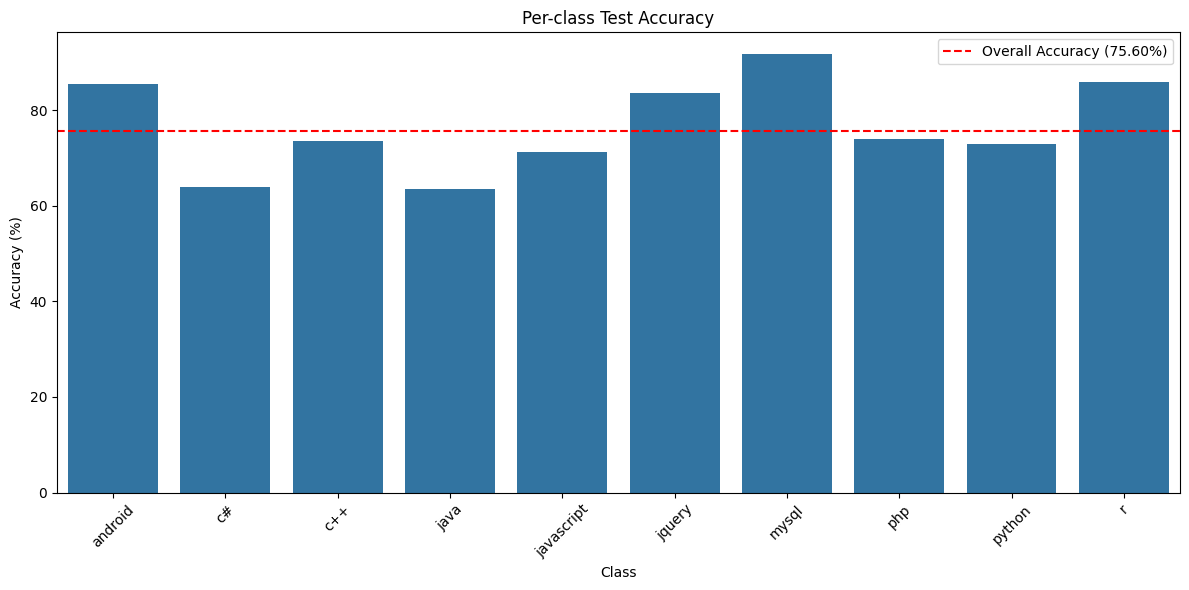

In [58]:
# Plot per-class accuracy
plt.figure(figsize=(12, 6))
classes = [x[0] for x in class_accuracies]
accuracies = [x[1] for x in class_accuracies]
sns.barplot(x=classes, y=accuracies)
plt.title('Per-class Test Accuracy')
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45)
plt.axhline(y=test_accuracy, color='r', linestyle='--', label=f'Overall Accuracy ({test_accuracy:.2f}%)')
plt.legend()
plt.tight_layout()
plt.show()

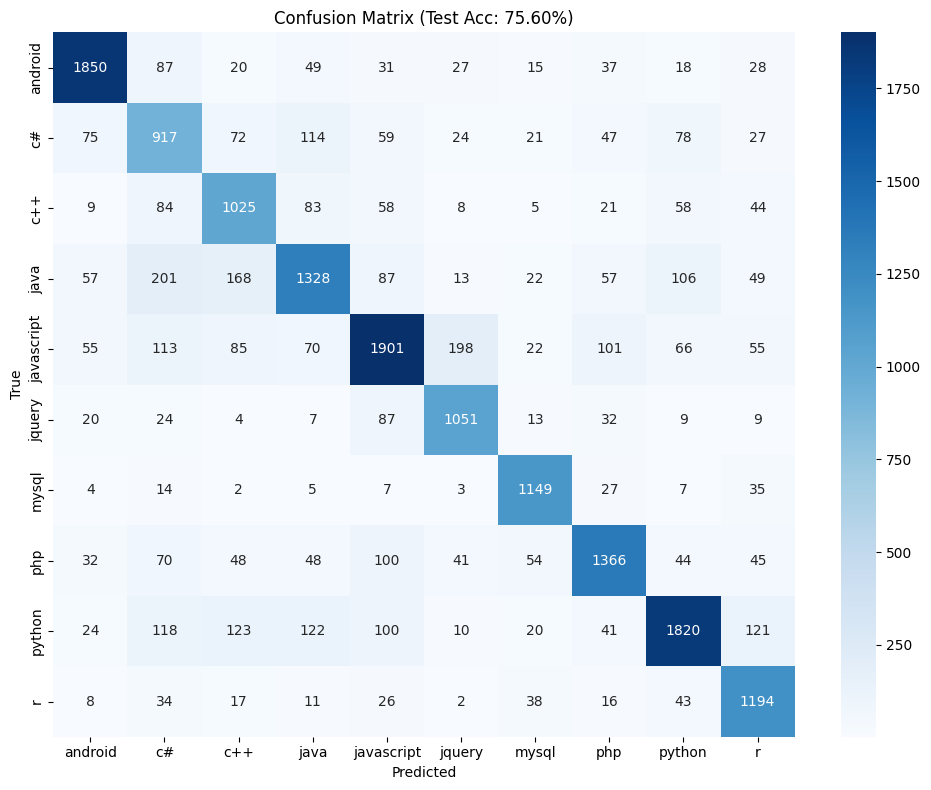

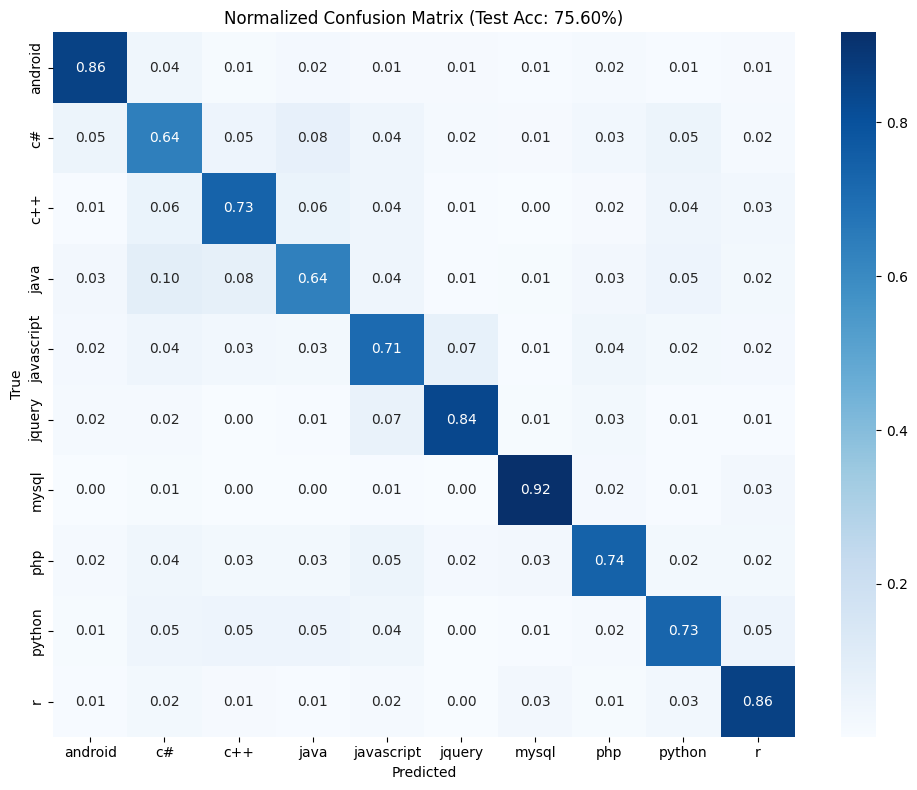

In [59]:
# Confusion Matrix
cm = confusion_matrix(all_true_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Test Acc: {test_accuracy:.2f}%)')
plt.tight_layout()
plt.show()

# Normalize confusion matrix (to show percentages)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Normalized Confusion Matrix (Test Acc: {test_accuracy:.2f}%)')
plt.tight_layout()
plt.show()

In [60]:
# Save the final model, vocabularies, and encoder classes
model_dict = {
    'model_state': model.state_dict(),
    'word_vocab': word_vocab,
    'char_vocab': char_vocab,
    'label_encoder_classes': label_encoder.classes_,
    'max_seq_len': MAX_SEQ_LENGTH,
    'max_word_len': MAX_WORD_LENGTH,
    'word_embed_dim': WORD_EMBEDDING_DIM,
    'char_embed_dim': CHAR_EMBED_DIM,
    'char_cnn_out_channels': CHAR_CNN_OUT_CHANNELS,
    'hidden_dim': HIDDEN_DIM,
    'num_layers': NUM_LAYERS,
    'dropout': DROPOUT,
}

final_model_save_path = 'stackoverflow_classifier.pt'
torch.save(model_dict, final_model_save_path)
print(f"Final model, vocabularies, and config saved to '{final_model_save_path}'")

Final model, vocabularies, and config saved to 'stackoverflow_classifier.pt'
